In [1]:
import chickpea
import numpy as np
import legume
import matplotlib.pyplot as plt

# Localization and Supercell Effects

In all frequency based simulation it is crucial that the size of the super-cell captures the
nature of the object to be simulated.

In the case of photonic crystal cavities, we approximate a defect in a finite crystal lattice by a tiling
of defects in an infinite crystal lattice. The notion is that if defect modes are truly localized they will
not interact across tiles.

Let's use the PhotonicCrystalCavity constructor to generate a series of H1 Crystals with different
super cell sizes values.

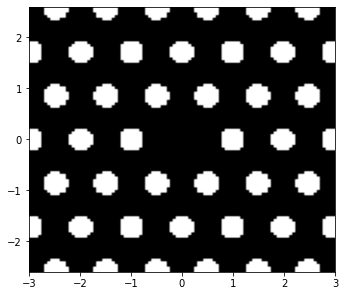

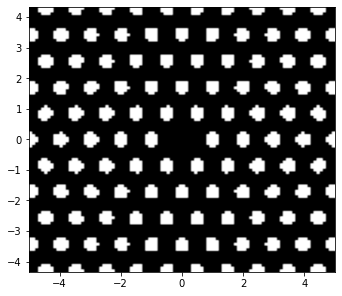

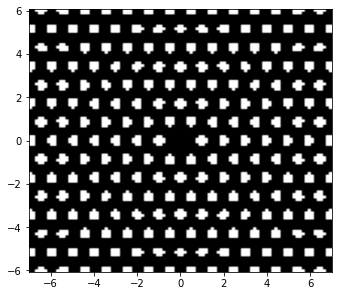

In [2]:
super_cell_sizes = ((6,6), (10,10), (14,14))

thickness = 0.4355
radius=0.234
eps = 2.21**2

pccs = [chickpea.PhotonicCrystalCavity('H', supercell_size=size,
                                       radius=radius,
                                       thickness= thickness,
                                       eps=eps, n=1) for size in super_cell_sizes]

cavities = [pcc.cavity() for pcc in pccs]

for cavity in cavities:
    legume.viz.eps_xy(cavity)

cmas = [chickpea.CavityModeAnalysis(pcc.cavity(), pcc.get_base_crystal(), defect_margins=[0.25,0.25], gmax=3) for pcc in pccs]

Band gap lower bound: 0.403028.
Band gap upper bound: 0.430009.
Band gap center: 0.416519.
Gap-midgap ratio: 0.064776.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



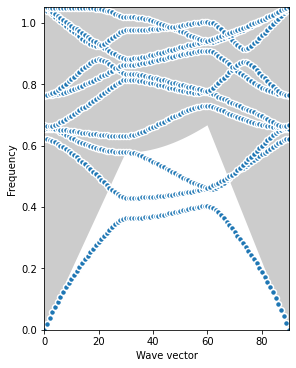

In [3]:
band_gaps, k_air, k_eps = cmas[0].find_band_gaps(band_tol=0.025,
                order=np.array([0]), # The order of modes that we care about.
                                     # TE modes are numbers [0,2,4,6,8]
                                     # We happen to know that higher order modes are
                                     # well above the bandgap
                trim_lc=True, # We only care about out of light-cone modes.
                lc_trim=0, # The lc-trim parameter governs how close to the light cone
                              # we tolerate.
                sample_rate=30,
                numeig=10)
gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])
bands_ax=legume.viz.bands(cmas[0].base_gme,  trim_light_cone=False, lc_trim=0.04, conecolor='#cccccc')

# There is only one band-gap for this crystal with properties.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0], band_gaps[0][1], band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))

Let's make sure we can find a mode in each region at the same time we can monitor the memory and time requirements
for each super cell size.

1.0100s total time for real part of frequencies, of which
  0.0870s for guided modes computation using the gmode_compute='exact' method
  0.0000s for inverse matrix of Fourier-space permittivity
  0.1050s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 687.88 MiB, increment: 189.44 MiB
6.2606s total time for real part of frequencies, of which
  0.2090s for guided modes computation using the gmode_compute='exact' method
  0.0000s for inverse matrix of Fourier-space permittivity
  0.6950s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 2057.27 MiB, increment: 1516.89 MiB
26.6721s total time for real part of frequencies, of which
  0.4050s for guided modes computation using the gmode_compute='e

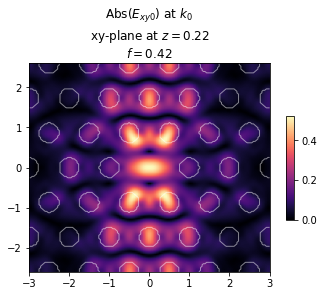

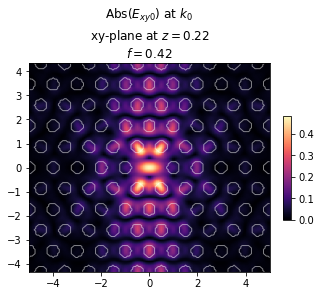

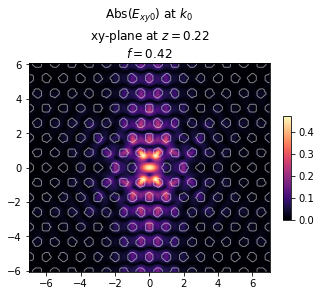

In [102]:
# load the memory profiler module for the %memit magic function
%load_ext memory_profiler

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'numeig': 1, # We happen to know this is a good number to fill the band gap.
                         # Run with higher value until you save modes outside of the band gap.
           'eig_solver': 'eigsh',
           'eig_sigma': band_gaps[0][2], # We target the center of the band gap
           'compute_im': False # We only want to calculate the loss rates for cavity modes.
           }
for cma in cmas:
    %memit cma.gme.run(kpoints=np.array([[0],[0]]), **options)
    legume.viz.field(cma.gme, 'e', 0, 0, z=thickness/2, component='xy', val='abs', N1=150, N2=150, norm=True)

## Dispersion relation of defect modes.

The dispersion relations plotted on band diagrams tell us a lot about the properties of modes.
The slope of the dispersion relation tells you the group velocity

Creating a path through the brioullin zone we can analyze the dispersion
relation of these modes for different super cell sizes.

In [50]:
skip_wait=True

In [51]:
bz_path = cavities[0].lattice.bz_path(pts=cmas[0].base_gme.phc.lattice.get_irreducible_brioullin_zone_vertices(),
                                   ns=5)

if skip_wait:
    freqs = np.load(open('./aux_files/Supercell_freqs.npy', 'rb'))
    kinds = np.load(open('./aux_files/Supercell_kinds.npy', 'rb'))
    freqs_im = np.load(open('./aux_files/Supercell_freqs_im.npy', 'rb'))
else:
    for i, cma in enumerate(cmas):
        options['compute_im'] = True
        cma.gme.run(kpoints=bz_path['kpoints'], **options)

    freqs = []
    kinds = []
    freqs_im = []
    for i, cma in enumerate(cmas):
        freqs.append(cma.gme.freqs.flatten())
        kinds.append(np.array(range(cma.gme.kpoints.shape[1])))
        freqs_im.append(cma.gme.freqs_im.flatten())

    freqs = np.array(freqs)
    kinds = np.array(kinds)
    freqs_im = np.array(freqs_im)
    np.save(open('./aux_files/Supercell_freqs.npy', 'wb'), freqs)
    np.save(open('./aux_files/Supercell_kinds.npy', 'wb'), kinds)
    np.save(open('./aux_files/Supercell_freqs_im.npy', 'wb'), freqs_im)

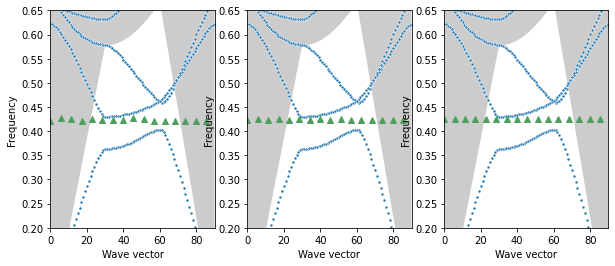

In [52]:
# Construct the figures:
fig, ax = plt.subplots(1,3)
for i, cma in enumerate(cmas):
        # Normalize kinds to plot over

        legume.viz.bands(cmas[0].base_gme, cone =True, ax=ax[i], conecolor='#cccccc',
                         markersize=3, markeredgewidth=0.5),

        ax[i].plot(kinds[i] *cmas[0].base_gme.kpoints.shape[1]/kinds[i].shape[0],freqs[i], marker='^', color='#4f9e5c', linewidth=0)


        ax[i].set_ylim(bottom=0.2, top=0.65)
fig.set_size_inches(10,4)


It's hard to see the detail here so let's zoom in.

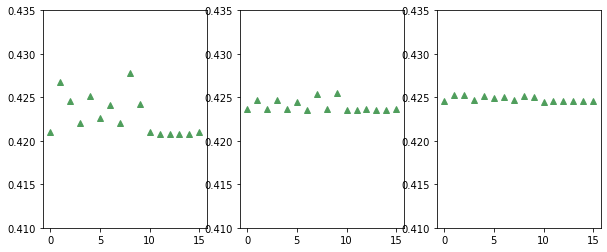

In [53]:
fig, ax = plt.subplots(1,3)

for i, cma in enumerate(cmas):

    ax[i].plot(kinds[i],freqs[i], marker='^', color='#4f9e5c', linewidth=0)
    ax[i].xlabel('Wave vector')
    ax[i].ylabel('Frequency')


    ax[i].set_ylim(bottom=0.41, top=0.435)
fig.set_size_inches(10,4)

What we see here is that the slope of the dispersion relation for the smaller super cells is non-zero.
This implies that the mode has *velocity*, it is NOT localized. As the super cell gets larger,
the dispersion relation better approaches the flat line expected. (Even at 14x14 the dispersion is noticeable).


Furthermore, there is the interesting observation that the latter third of this plot is significantly flatter
then the first two thirds. We can interpret this as a directionality to our localization.

Let us plot these k-vectors on the xy plane and compare them to our field plot.

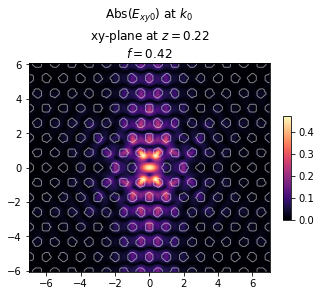

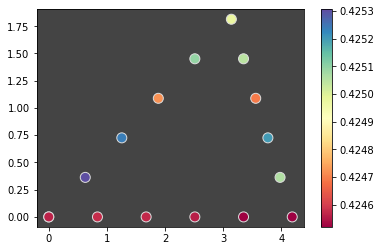

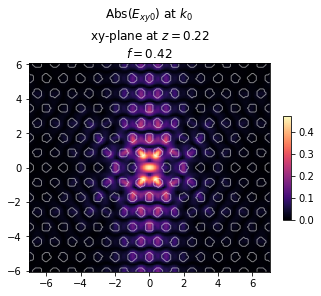

In [82]:
fig, ax = plt.subplots()
sc=ax.scatter(bz_path['kpoints'][0],bz_path['kpoints'][1], c=freqs[2],
            cmap='Spectral',s=100 , edgecolors='#dddddd',norm=plt.Normalize())
fig.colorbar(sc)

ax.set_facecolor('#444444')
ax.title('k points')

legume.viz.field(cmas[2].gme, 'e', 0, 0, z=thickness/2, component='xy', val='abs',
                 N1=150, N2=150, norm=True)

We see that the field has much lower amplitude on the x-axis then on the y-axis. We cab see from the field that the mode
is much better localized along the x-axis then the y-axis. This coincides with the constant frequency (
Thus zero group velocity) along the x-axis. What we will find is that as we sample k vectors closer to the y axis,
the variability in frequency will increase.


## Quality factor in defect modes.

How do these super ncell effects impact the quality factor?

Let's plot a similar heat map of imaginary frequency and quality factor for each of our 3 super cells.

We will also overlay the average value of the Q factor and imaginary frequency for each super cell.

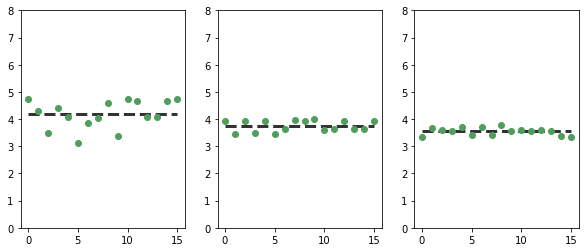

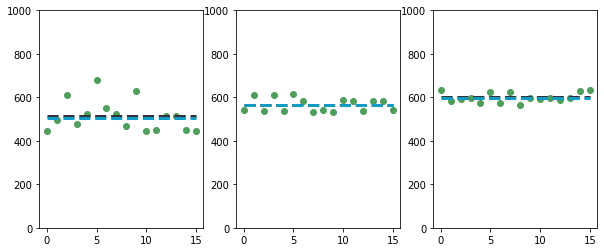

In [106]:
# Construct the figures:
Q=freqs/2/freqs_im

fig_if, ax_if = plt.subplots(1,3)
fig_Q, ax_Q = plt.subplots(1,3)

for i, cma in enumerate(cmas):
        mean_im_freq = np.mean(freqs_im[i])
        mean_im_freq_array = np.ones(kinds[i].shape)*mean_im_freq
        # Normalize kinds to plot over
        ax_if[i].plot(kinds[i], mean_im_freq_array*10e3, color='#333333', linestyle='dashed', linewidth=3)

        ax_if[i].plot(kinds[i], freqs_im[i]*10e3, marker='o', color='#4f9e5c', linewidth=0)
        ax_if[i].xlabel('k index')
        ax_if[i].ylabel('imaginary frequency')
        ax_if[i].set_ylim(0,8)

        # Quality factor
        mean_Q = np.mean(Q[i])
        mean_Q_2 = np.mean(freqs[i])/2/mean_im_freq

        mean_Q_array=np.ones(kinds[i].shape)*mean_Q
        mean_Q2_array=np.ones(kinds[i].shape)*mean_Q_2
        # Normalize kinds to plot over
        ax_Q[i].plot(kinds[i], Q[i], marker='o', color='#4f9e5c', linewidth=0)
        ax_Q[i].plot(kinds[i], mean_Q_array, color='#333333', linestyle='dashed', linewidth=3)
        ax_Q[i].plot(kinds[i], mean_Q2_array, color='#129ac7', linestyle='dashed', linewidth=3)
        ax_Q[i].xlabel('k index')
        ax_Q[i].ylabel('Q-factor')
        ax_Q[i].set_ylim(0,1000)


fig_if.set_size_inches(10,4)
fig_Q.set_size_inches(10,4)

What we see here is much the same. As the supercell gets larger the quality factor and
imaginary frequency begin to converge. What we do not see is the same directionality that we saw with the
frequency. This is because while the group velocity is a vector. The imaginary frequency and hence quality factor is a
function of (among other things) the "density of states" around a particular k-value.
The density of states is a *scalar* function of the magnitude of the group velocity, so unless the mode is localized
in every direction you should expect the imaginary frequency to change with k.


## Managing super cell effects

From this data we can make some observations about how to evaluate crystals suffering from super cell effects.
First, even for extremely poorly localized modes we can extract an order of magnitude approximation for Q factor
and better for the frequency. Thus, the bulk of improvement from an optimization algorithm for Q can be done at
low super-cell size with more precise tuning done by increasing the size of the super-cell.

Second by taking the average over several k points we can find reasonable approximations for Q for
poorly localized modes. We saw that as we increase the super cell size the time and memory requirements scale
quadratically, however sampling more k-points increases overhead just linearly. For large cavities, sampling k-points
can be a more effective method.

This kind of averaging is the approach that the [legume tutorials](.\docs\examples\07_Enhancing_your_GME_optimization.ipynb)
takes when optimizing a L4/3 crystal. It is also the approach we take when optimizing a mode in [the H2 crystal](07_Optimizing_the_H2_Cavity.ipynb).
